# Milestone 2 - Natural Language Processing
**Author: Hafiz Fahrurrozi**

Natural language processing is a major topic in machine learning. To improve our comprehension on the topic, we will do a simple project on news categorization. For this project, we will use a news category dataset available on [kaggle](https://www.kaggle.com/rmisra/news-category-dataset) to show how to prepare and use machine learning to do natural language processing. In this particular case, we will do news categorization using Word2Vec and LSTM.

## Import Libraries
Import libraries used in the notebook. Particularly we needed pandas, numpy, pyplot, and seaborn for data exploration; sklearn to preprocess and metrics evaluation; nltk, re, gensim, and keras for text preprocessing; keras and keras tuner for machine learning modelling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import re
import gensim
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

Load Cython extension to speed up Word2Vec performance

In [2]:
%load_ext Cython

## Data Loading and Cleaning
Loading the data from .json file to pandas and cleaning the data for exploration

In [24]:
raw = pd.read_json('News_Category_Dataset_v2.json', lines=True)

### Simple exploration
News category spread:

<AxesSubplot:>

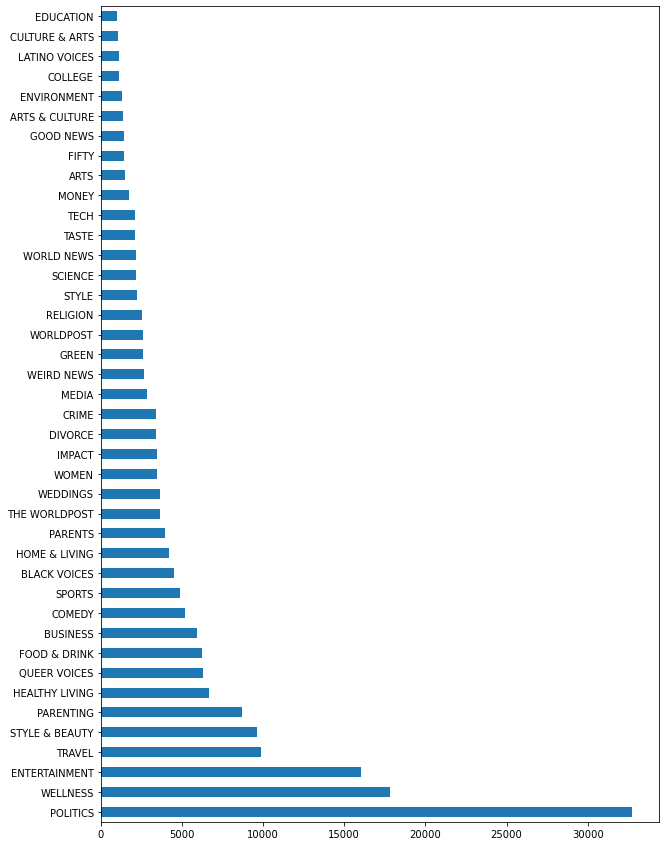

In [25]:
raw.category.value_counts().plot(kind='barh', figsize=(10,15))

A peek on the data:

In [5]:
raw.head(10)

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,Ron Dicker,https://www.huffingtonpost.com/entry/morgan-fr...,"""It is not right to equate horrific incidents ...",2018-05-26
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,Ron Dicker,https://www.huffingtonpost.com/entry/donald-tr...,"It's catchy, all right.",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,Andy McDonald,https://www.huffingtonpost.com/entry/mike-myer...,"Myer's kids may be pushing for a new ""Powers"" ...",2018-05-26
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,Todd Van Luling,https://www.huffingtonpost.com/entry/hulu-what...,You're getting a recent Academy Award-winning ...,2018-05-26


### Data Cleaning
Here we merged several similar category into one category, merged headline and short summary columns into content column, drop the unneeded columns, and reformat the date column to show yearly data.

In [6]:
raw['category'] = raw.category.replace({'HEALTHY LIVING':'LIFESTYLE',
                                        'WELLNESS':'LIFESTYLE',
                                        'FIFTY':'LIFESTYLE',
                                        'HOME & LIVING':'LIFESTYLE',
                                        'COMEDY':'ENTERTAINMENT',
                                        'MEDIA':'ENTERTAINMENT',
                                        'STYLE & BEAUTY':'FASHION',
                                        'WOMEN':'FASHION',
                                        'STYLE':'FASHION',
                                        'PARENTS':'PARENTING',
                                        'QUEER VOICES':'OPINION',
                                        'BLACK VOICES':'OPINION',
                                        'LATINO VOICES':'OPINION',
                                        'FOOD & DRINK':'CULINARY',
                                        'TASTE':'CULINARY',
                                        'BUSINESS':'FINANCE',
                                        'MONEY':'FINANCE',
                                        'THE WORLDPOST':'WORLD',
                                        'WORLDPOST':'WORLD',
                                        'WORLD NEWS':'WORLD',
                                        'GREEN':'ENVIRONMENT',
                                        'SCIENCE':'EDUCATION',
                                        'COLLEGE':'EDUCATION',
                                        'ARTS':'ARTS & CULTURE',
                                        'CULTURE & ARTS':'ARTS & CULTURE',
                                        'WEIRD NEWS':'TRIVIA',
                                        'GOOD NEWS':'TRIVIA',
                                        'RELIGION':'TRIVIA',
                                        'CRIME':'TRIVIA',
                                        'TECH':'TRIVIA',
                                        'IMPACT':'TRIVIA',
                                        'DIVORCE':'WEDDINGS'
                                        })

raw['content'] = raw.headline + ' ' + raw.short_description

cln = raw.drop(['headline','short_description','authors','link'], axis=1)
cln.date = cln.date.dt.to_period("Y")
cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype        
---  ------    --------------   -----        
 0   category  200853 non-null  object       
 1   date      200853 non-null  period[A-DEC]
 2   content   200853 non-null  object       
dtypes: object(2), period[A-DEC](1)
memory usage: 4.6+ MB


## Data Exploration
Here we can see how the data distribution and what insight we can gain from them. First is count of articles on each category:

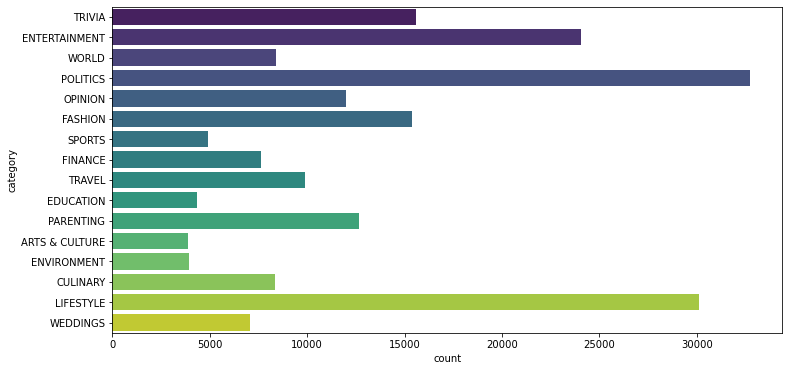

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(data=cln, y='category', palette='viridis')
plt.show()

From the distribution, the highest count is politics, followed by lifestyle and entertainment news. From this trend, we can infer that most user of the website came for those three categories. It might be interesting to note that education, arts & culture, and environment have the least number of articles.

Next we will see the distribution of news category by year:

<AxesSubplot:xlabel='date', ylabel='count'>

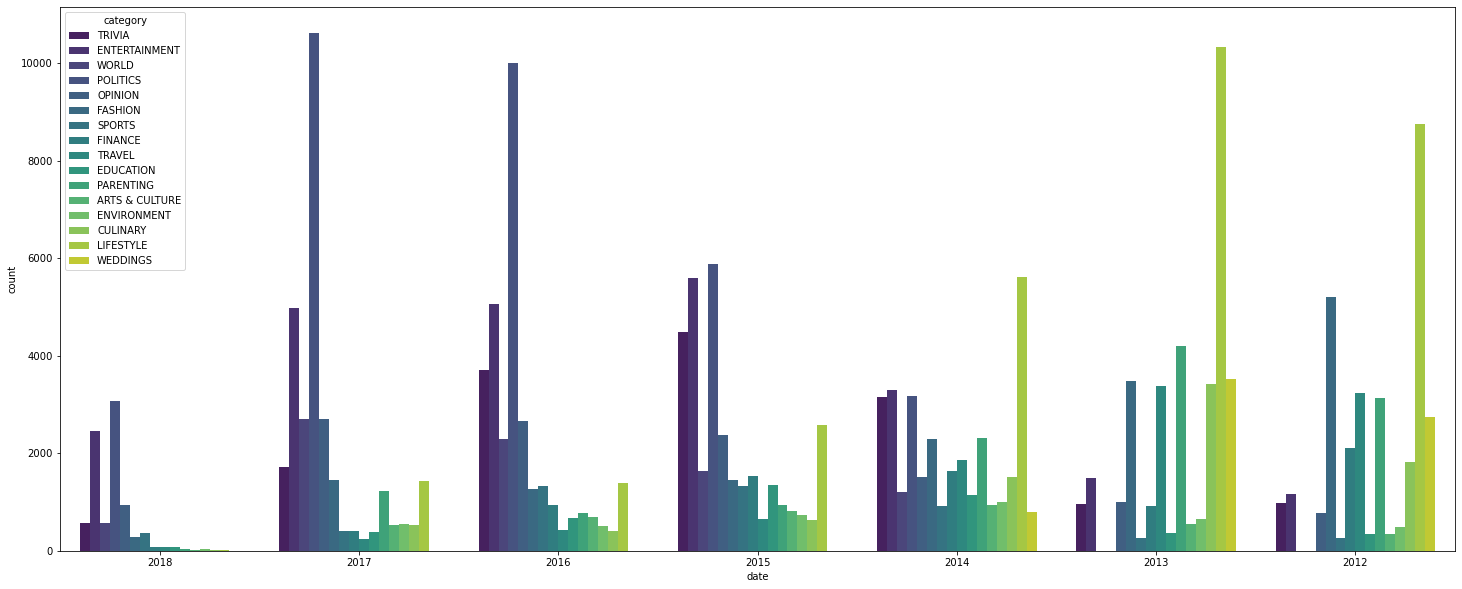

In [8]:
plt.figure(figsize=(25,10))
sns.countplot(data=cln, x='date', hue='category', palette='viridis')

Here we see that lifestyle is the prominent category on 2012-2014, but replaced with entertainment and politics news circa 2015-2018. The change in content category coincide with the campaigns before US presidential election of 2016, which might spark an increase of user interest in government policy and political stability. The Trump administration was also regularly making news, indicated by the number of politics related news on 2016-2018.

<AxesSubplot:xlabel='date', ylabel='count'>

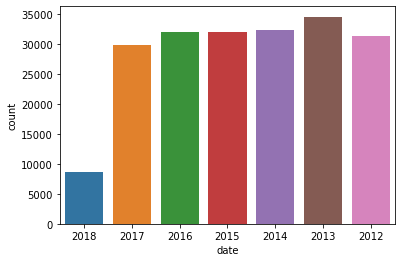

In [9]:
sns.countplot(data=cln, x='date')

Here we see that the website is the most active at 2013 - with lifestyle-related news on the rise. The 2018 news count is smaller because the data is taken on May 2018.

## Preprocessing
Before the news data can be fed into the machine learning model, it need to be preprocessed into vectors representing the words. In this notebook, I used word2vec module in gensim library to learn the word vector. Text cleaning is done using NLTK library with stopwords, punkt, and wordnet package, and word encoding is done using keras tokenizer.

First, download the required package and split the data into train-validation-test set. We also encode the target label using LabelBinarizer.

In [10]:
# download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# saving number of target class
cats = len(cln.category.unique())

# data splitting
y = cln.category
x = cln.content

xt,xg,yt,yg = sklearn.model_selection.train_test_split(x,y,test_size=0.1, stratify=y, random_state=52)
xt,xv,yt,yv = sklearn.model_selection.train_test_split(xt,yt,test_size=(1/3), stratify=yt, random_state=52)

# target label encoding
encoder = sklearn.preprocessing.LabelBinarizer()
ytt = encoder.fit_transform(yt)
yvt = encoder.transform(yv)
ygt = encoder.transform(yg)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Next we split the sentences into words using nltk tokenize module. We also apply lemmatization to the data to simplify the words to their base forms, then filter the words using stopword corpus.

In [11]:
# sentence splitting
def token_txt(data):
    xtok = []
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemma = nltk.stem.WordNetLemmatizer()
    for par in data.values:
        tmp = []
        sentences = nltk.sent_tokenize(par)
        for sent in sentences:
            sent = sent.lower()
            tokens = tokenizer.tokenize(sent)
            filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
            for wor in filtered_words:
                lem = lemma.lemmatize(wor)
                wor = lem
            tmp.extend(filtered_words)
        xtok.append(tmp)
    return(xtok)

xtt = token_txt(xt)
xvt = token_txt(xv)
xgt = token_txt(xg)

After the sentences are split into words, then we learn the words vector using Word2Vec from gensim. We trim less occuring words (below 5 times) to improve words significance.

In [12]:
%%time
outvec = 300
# learn word vectors
w2v_model = gensim.models.Word2Vec(sentences=xtt, vector_size=outvec, min_count=5, workers=4)
w2v_model.save('m2p2.wordvectors')

# keep keyvector, delete model
wv = w2v_model.wv
del(w2v_model)

# number of words library
print('Number of words :',len(wv))

# check a word similarity vector
display(wv.most_similar('good'))

Number of words : 25870


[('bad', 0.8535224795341492),
 ('great', 0.6651961803436279),
 ('scary', 0.6173112988471985),
 ('weird', 0.6001114249229431),
 ('familiar', 0.5991073250770569),
 ('breaking', 0.5979569554328918),
 ('wrong', 0.5970488786697388),
 ('mcmullen', 0.596914529800415),
 ('sad', 0.5949071645736694),
 ('better', 0.594200849533081)]

Wall time: 8 s


Now we've got the vector for each words. Next we encode the words into numbers using keras tokenizer's text to sequences.

In [13]:
# declare tokenizer for model input
tknz = keras.preprocessing.text.Tokenizer()
tknz.fit_on_texts(xtt)

# convert to numbers
xti = tknz.texts_to_sequences(xtt)
xvi = tknz.texts_to_sequences(xvt)
xgi = tknz.texts_to_sequences(xgt)

# print first 5 words for checking
word_index = tknz.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 5:
        break

new -> 1
trump -> 2
one -> 3
time -> 4
people -> 5


Next we use 1.5 of the mean as max word count. We trim sentences longer than that value and fill sentences with lower word count with paddings.

In [14]:
tem = 0
for i in range(len(xti)):
    tem += len(xti[i])
invec = int(1.5*tem/len(xti))

xto = keras.preprocessing.sequence.pad_sequences(xti, maxlen=invec)
xvo = keras.preprocessing.sequence.pad_sequences(xvi, maxlen=invec)
xgo = keras.preprocessing.sequence.pad_sequences(xgi, maxlen=invec)
len(xto[0])

26

Next we make a weight matrix using Word2Vec vector and keras tokenizer index.

In [15]:
vocab_size = len(tknz.word_index) + 1

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, outvec))
    for word, i in vocab.items():
        if word not in model:
            weight_matrix[i] = 0
        else:
            weight_matrix[i] = model[word]
    return weight_matrix

emvec = get_weight_matrix(wv, word_index)

## Model Building
Here we will compare a base LSTM model with an optimized one. The optimization used bayesian optimization which aims to achieve lowest validation loss to improve the model robustness. We only use several test with low number of epochs to speed up the optimization process.

In [16]:
tf.keras.backend.clear_session()
def build_model(hp):
    mod = tf.keras.Sequential()
    mod.add(keras.layers.Embedding(vocab_size, output_dim=outvec, weights=[emvec], input_length=invec, trainable=False))
    mod.add(keras.layers.LSTM(hp.Choice('LSTM_units',[64,128])))
    mod.add(keras.layers.Dropout(hp.Choice('DO',[0.2,0.3,0.4,0.5])))
    mod.add(keras.layers.Dense(cats, activation='softmax'))
    mod.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[5e-3,4e-3,3e-3,2e-3,1e-3])), loss='categorical_crossentropy', metrics=['accuracy'])
    return mod

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=8,
    seed=52,
    project_name=None,
    overwrite=True
)

tuner.search(xto, ytt, epochs=6, validation_data=(xvo, yvt), batch_size=6500)
tuner.results_summary(2)

Trial 8 Complete [00h 04m 06s]
val_loss: 1.1832717657089233

Best val_loss So Far: 1.1758592128753662
Total elapsed time: 00h 18m 32s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\untitled_project
Showing 2 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
LSTM_units: 128
DO: 0.3
learning_rate: 0.005
Score: 1.1758592128753662
Trial summary
Hyperparameters:
LSTM_units: 128
DO: 0.3
learning_rate: 0.005
Score: 1.1771060228347778


Next we build the base model and the optimized model. We also defined an early stopping callback to stop the learning process if the validation loss doesn't improve after 5 iterations.

In [17]:
tf.keras.backend.clear_session()
mod1 = keras.models.Sequential()
mod1.add(keras.layers.Embedding(vocab_size, output_dim=outvec, weights=[emvec], input_length=invec, trainable=False))
mod1.add(keras.layers.LSTM(units=64))
mod1.add(keras.layers.Dropout(0.2))
mod1.add(keras.layers.Dense(cats, activation='softmax'))
mod1.compile(optimizer=keras.optimizers.Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])

best_hp = tuner.get_best_hyperparameters()[0]
mod2 = tuner.hypermodel.build(best_hp)

cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mod1.summary()
mod2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 300)           21036600  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
Total params: 21,131,080
Trainable params: 94,480
Non-trainable params: 21,036,600
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 300)           21036600  
___________________

## Model Training
Both models are fitted to the training set and validated with validation set. Setting the max epochs to 50 to let the model learn longer, if not cut by early stopping.

In [18]:
%%time
hist1 = mod1.fit(xto,ytt,batch_size=6500,epochs=50,validation_data=(xvo,yvt),callbacks=[cb],verbose=2)

Epoch 1/50
19/19 - 21s - loss: 1.9473 - accuracy: 0.4049 - val_loss: 1.5324 - val_accuracy: 0.5300
Epoch 2/50
19/19 - 19s - loss: 1.4563 - accuracy: 0.5558 - val_loss: 1.3537 - val_accuracy: 0.5851
Epoch 3/50
19/19 - 19s - loss: 1.3386 - accuracy: 0.5889 - val_loss: 1.2798 - val_accuracy: 0.6059
Epoch 4/50
19/19 - 19s - loss: 1.2749 - accuracy: 0.6068 - val_loss: 1.2410 - val_accuracy: 0.6163
Epoch 5/50
19/19 - 19s - loss: 1.2352 - accuracy: 0.6197 - val_loss: 1.2137 - val_accuracy: 0.6227
Epoch 6/50
19/19 - 19s - loss: 1.2024 - accuracy: 0.6284 - val_loss: 1.1917 - val_accuracy: 0.6304
Epoch 7/50
19/19 - 19s - loss: 1.1779 - accuracy: 0.6351 - val_loss: 1.1796 - val_accuracy: 0.6344
Epoch 8/50
19/19 - 19s - loss: 1.1573 - accuracy: 0.6414 - val_loss: 1.1643 - val_accuracy: 0.6397
Epoch 9/50
19/19 - 19s - loss: 1.1407 - accuracy: 0.6463 - val_loss: 1.1616 - val_accuracy: 0.6397
Epoch 10/50
19/19 - 19s - loss: 1.1277 - accuracy: 0.6492 - val_loss: 1.1511 - val_accuracy: 0.6435
Epoch 11/

In [19]:
%%time
hist2 = mod2.fit(xto,ytt,batch_size=6500,epochs=50,validation_data=(xvo,yvt),callbacks=[cb],verbose=2)

Epoch 1/50
19/19 - 41s - loss: 1.8610 - accuracy: 0.4289 - val_loss: 1.4799 - val_accuracy: 0.5426
Epoch 2/50
19/19 - 40s - loss: 1.4257 - accuracy: 0.5633 - val_loss: 1.3315 - val_accuracy: 0.5900
Epoch 3/50
19/19 - 39s - loss: 1.3126 - accuracy: 0.5959 - val_loss: 1.2657 - val_accuracy: 0.6063
Epoch 4/50
19/19 - 39s - loss: 1.2528 - accuracy: 0.6133 - val_loss: 1.2250 - val_accuracy: 0.6206
Epoch 5/50
19/19 - 39s - loss: 1.2068 - accuracy: 0.6265 - val_loss: 1.2094 - val_accuracy: 0.6249
Epoch 6/50
19/19 - 39s - loss: 1.1768 - accuracy: 0.6357 - val_loss: 1.1756 - val_accuracy: 0.6362
Epoch 7/50
19/19 - 39s - loss: 1.1502 - accuracy: 0.6427 - val_loss: 1.1626 - val_accuracy: 0.6393
Epoch 8/50
19/19 - 39s - loss: 1.1276 - accuracy: 0.6494 - val_loss: 1.1506 - val_accuracy: 0.6440
Epoch 9/50
19/19 - 39s - loss: 1.1015 - accuracy: 0.6559 - val_loss: 1.1406 - val_accuracy: 0.6477
Epoch 10/50
19/19 - 39s - loss: 1.0874 - accuracy: 0.6604 - val_loss: 1.1366 - val_accuracy: 0.6476
Epoch 11/

## Model Evaluation
Training history is used to evaluate the training result. Here we can see the training and validation loss for both models.

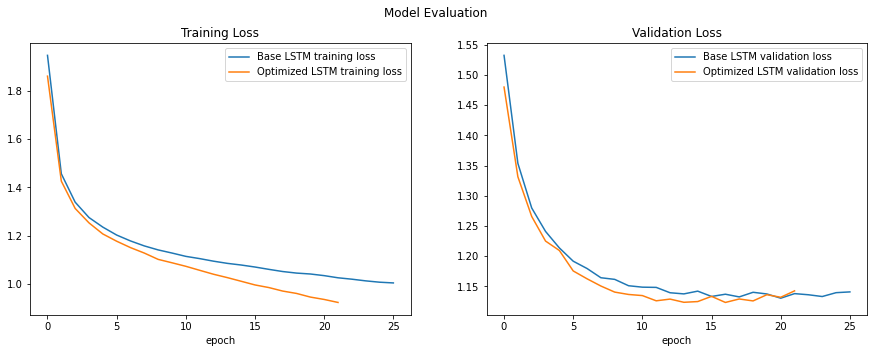

In [20]:
plt.figure(figsize=(15,5))
plt.suptitle('Model Evaluation')
for i,j in zip([hist1,hist2],['Base LSTM','Optimized LSTM']):
    plt.subplot(1,2,1)
    plt.title('Training Loss')
    plt.plot(i.history['loss'], label=f'{j} training loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
    plt.subplot(1,2,2)
    plt.title('Validation Loss')
    plt.plot(i.history['val_loss'], label=f'{j} validation loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
plt.show()

After that, we will evaluate the metrics (precision, recall, F1) for each models

In [21]:
ygpb = mod1.predict(xgo)
ygpo = mod2.predict(xgo)

print('Base model weighted ROC AUC score :',sklearn.metrics.roc_auc_score(ygt, ygpb, average='weighted', multi_class='ovr'))
print('Base model score:\n\n',sklearn.metrics.classification_report(np.argmax(ygt, axis=1), np.argmax(ygpb, axis=1), target_names=encoder.classes_, digits=3))
print('Optimized model weighted ROC AUC score :',sklearn.metrics.roc_auc_score(ygt, ygpo, average='weighted', multi_class='ovr'))
print('Optimized model score:\n\n',sklearn.metrics.classification_report(np.argmax(ygt, axis=1), np.argmax(ygpo, axis=1), target_names=encoder.classes_, digits=3))

Base model weighted ROC AUC score : 0.9391896450369815
Base model score:

                 precision    recall  f1-score   support

ARTS & CULTURE      0.445     0.335     0.382       388
      CULINARY      0.728     0.775     0.751       832
     EDUCATION      0.523     0.372     0.435       433
 ENTERTAINMENT      0.615     0.643     0.629      2405
   ENVIRONMENT      0.475     0.377     0.420       395
       FASHION      0.707     0.650     0.678      1539
       FINANCE      0.506     0.465     0.485       764
     LIFESTYLE      0.669     0.747     0.706      3012
       OPINION      0.633     0.479     0.545      1197
     PARENTING      0.637     0.708     0.671      1263
      POLITICS      0.720     0.819     0.766      3274
        SPORTS      0.675     0.537     0.598       488
        TRAVEL      0.675     0.696     0.685       989
        TRIVIA      0.480     0.407     0.440      1557
      WEDDINGS      0.815     0.795     0.805       708
         WORLD      0.620   

## Model Saving
We save the models into h5 files for deployment purposes - not included in this notebook though.

In [22]:
mod1.save('rnn1-p2m2.h5')
mod2.save('rnn2-p2m2.h5')

## Model Inference
We test the model to predict new data, which is a randomly written news headline and content. Similar preprocessing as our train data is done using transform method to prevent information leakage.

In [23]:
txt_samp = pd.Series(["President Trump To Give Aid for The Mexican Affected by COVID-19",
                      "Stay Healthy with These Steps! Excercise regularly and eat healthy food",
                      "Mass Bombings in A Church with Hundreds of Casualties. Pope urges believers to stay at home",
                      "Small Houses Are Trending, People Migrate to New Homes. Young people are into the fad, particularly the modular home.",
                      "Jeans Away, Bikini Can Stay! See the latest trend on summer wear",
                      "Graham Bell And Anne-Marie Releases A New Song Titled Durable. Both musicians have held a press conference and said that they will release a new collaborative album soon",
                      "New Couples Are More Likely To Divorce Than Older Ones. The latest survey shows that younger couples tend to choose divorce when faced with interpersonal difficulties",
                      "Highway Robbery On The Rise! Police representative Hugh Jackman said that there is an increase of nearly 500% on highway robbery cases",
                      "Boston To Face Derby At The Nines. The club will face its fellow club on September 25th",
                      "College Crackdown On Fraudulent Club Activities. A representative said that the club have misappropriated their fund for 'non-constructive' events and folly"
                     ])
samp = token_txt(txt_samp)
sin = tknz.texts_to_sequences(samp)
sout = keras.preprocessing.sequence.pad_sequences(sin, maxlen=invec)

spred1 = mod1.predict(sout)
spred2 = mod2.predict(sout)
print(encoder.inverse_transform(spred1))
print(encoder.inverse_transform(spred2))

['POLITICS' 'LIFESTYLE' 'TRIVIA' 'LIFESTYLE' 'FASHION' 'ENTERTAINMENT'
 'WEDDINGS' 'POLITICS' 'SPORTS' 'EDUCATION']
['POLITICS' 'LIFESTYLE' 'TRIVIA' 'LIFESTYLE' 'FASHION' 'ENTERTAINMENT'
 'WEDDINGS' 'POLITICS' 'SPORTS' 'EDUCATION']


## Conclusion
From the EDA, we can see a shift in content category by 2014-2015 where politics and entertainment emerge as the most popular categories. As seen on the graph, 2013 have the most numbers of news content with most of them are lifestyle news. The 2016-2018 period sees the highest number of politics and entertainment news, which can be said that as the political situation gains more attention the entertainment is there to cover it up.

The result shows the both models were able to predict validation set with ~65% accuracy and achieved 0.64 on weighted F1 score. Feeding the model with new data also shows the predictions made were fairly accurate with the news content, with both model predicted the same results. We can infer from the model that as long as the news content is common enough, it won't be misclassified and the reverse holds true. If the news content is uncommon, there is a higher chance of the model failing to predict the category.

Trivia news (weird news, good news, religion, crime, tech, and impact) is the most diverse category, thus the model have difficulties recognizing the keywords and patterns, resulting on lower overall scores. On the contrary, weddings news (weddings and divorce) contents are distinct enough even though the category have small count of news (~6000), it has the highest precision and f1 score on both models.